In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from env.propagators.hierarchicalPropagator import H2PlanTrackPropagator
prop = H2PlanTrackPropagator(8, h1_step=3, h2_step=1200, max_dist=2000, safe_dist=1000, device="cuda")

from agent.hierarchicalAgent import trackCW_SAC
action_bounds = [1., 1., 1.]
sigma_bounds=  [1.]*3
# sigma_bounds=  [torch.inf]*3
h2out_ub = [ 0.06]*3
h2out_lb = [-0.06]*3
hAgent = trackCW_SAC(obs_dim=prop.obs_dim,
                    action_bounds=action_bounds,
                    sigma_upper_bounds=sigma_bounds,
                    h1a_hiddens=[512]*8, 
                    h2a_hiddens=[512]*4, 
                    h1c_hiddens=[512]*8,
                    h2out_ub=h2out_ub, 
                    h2out_lb=h2out_lb, 
                    h2a_lr=2e-3,
                    device="cuda")

import data.buffer
buffer_keys = ["states", "obss", "actions", "rewards", "next_states", "next_obss",
               "dones", "terminal_rewards"]
buffer = data.buffer.replayBuffer(buffer_keys, capacity=10000, batch_size=640)

from trainer.hierarchicalTrainer import H2Trainer, H2PlanTrackTrainer
loss_keys = ["critic_loss", "actor_loss"]
T = H2PlanTrackTrainer(prop, hAgent, buffer, loss_keys)

T.hAgent[1].load("../model/plan_track_1200/h1.ptd")
# hAgent.load("../model/plan_track_1")

In [ ]:
log = T.offPolicyTrain(20, 100, states_num=256, h1_explore_eps=0)

In [ ]:
plt.plot(log["total_rewards"])
plt.show()

In [ ]:
plt.plot(log["critic_loss"])
plt.show()

In [10]:
td, _ = T.offPolicySim()

In [ ]:
loss, logs = T.h2Pretrain(episode=200, gamma=0.99)
logs = np.array(logs)
plt.plot(loss[:])
plt.show()

In [16]:
batch_size = 256
states = prop.randomInitStates(batch_size)
obss = prop.getObss(states)
targets_seqs = torch.zeros((prop.h1_step,batch_size,3), device=prop.device)
for i in range(prop.h1_step):
    _, targets_seqs[i] = hAgent[0].act(obss)
rewards = prop.getSeqPlanRewards(states, targets_seqs, require_grad=True)

In [2]:
states = prop.randomInitStates(1)
targets = torch.tensor([[0.1, -0.2, 0.5]], device=prop.device)
# targets = torch.zeros((1, 3), device=prop.device)
res = T.h2Sim(states, targets, h1noise=False, prop_with_grad=False)
td = res[0]

In [18]:
states = res[1]
targets = torch.tensor([[0.1, 0.2, 0]], device=prop.device)
res = T.h2Sim(states, targets, h1noise=False, prop_with_grad=False)
td = res[0]

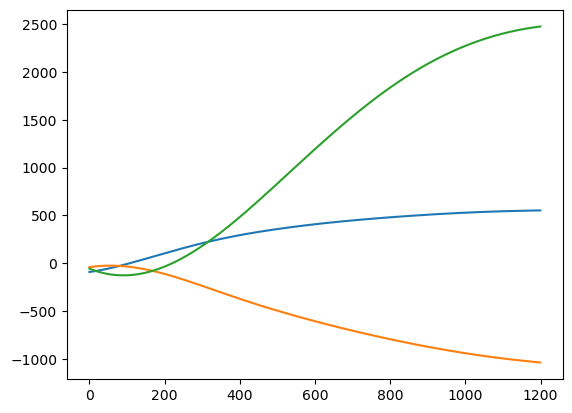

In [3]:
plt.plot(td["states"][:,0,:3].detach().cpu().numpy())
plt.show()

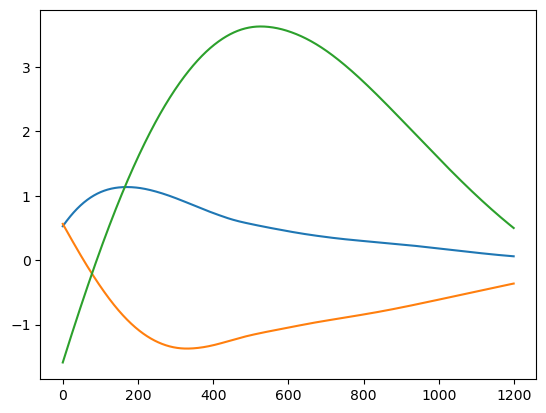

In [4]:
plt.plot(td["states"][:,0,3:6].detach().cpu().numpy())
plt.show()

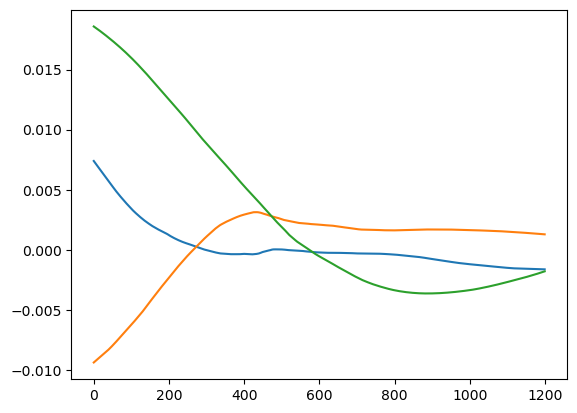

In [5]:
plt.plot(td["actions"][:,0,:3].detach().cpu().numpy())
plt.show()

In [22]:
hAgent.save("../model/plan_track_1200")

multi process

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from env.propagators.hierarchicalPropagator import H2PlanTrackPropagator
from trainer.hierarchicalTrainer import H2PlanTrackTrainerV2
from trainer.myMp.mpH2 import mpH2Trainer
from data.buffer import replayBuffer

device = "cuda"
propArgs = {
    "n_debris": 8
}
hAgentArgs = {
    "action_bounds": [1., 1., 1.],
    "sigma_upper_bounds": [1e2]*3,
    "h1a_hiddens": [512]*6, 
    "h2a_hiddens": [512]*4, 
    "h1c_hiddens": [512]*6,
    "h2out_ub": [ 0.06]*3, 
    "h2out_lb": [-0.06]*3, 
    "h2a_lr": 2e-3,
}
bufferArgs = {
    "keys": None,
    "capacity": 10000,
    "batch_size": 640,
}
loss_keys = ["critic_loss", "actor_loss"]
trainerArgs = {
    "propArgs": propArgs,
    "hAgentArgs": hAgentArgs,
    "bufferArgs": None,
    "device": device,
    "loss_keys": loss_keys
}
buffer = replayBuffer(**bufferArgs)
mpt = mpH2Trainer(8, trainerCls=H2PlanTrackTrainerV2, 
                trainerArgs=trainerArgs,
                buffer=buffer)
mpt.main_agent.load("../model/plan_track_1")

In [ ]:
mpt.train(2, 100)

DDPG seq

In [ ]:
from agent.agent import DDPG
action_dim = prop.h1_action_dim*prop.h1_step
ddpg = DDPG(obs_dim=prop.obs_dim, 
            action_dim=action_dim, 
            actor_hiddens=[512]*8, 
            critic_hiddens=[512]*8,
            action_upper_bounds=[1]*action_dim,
            action_lower_bounds=[-1]*action_dim,
            device=prop.device)
# ddpg.load("../model/ddpg_seq/ddpg_seq.ptd")

In [ ]:
import torch.nn.functional as F
import numpy as np
from rich.progress import Progress
N = 5000
batch_size = 512
explore_eps = 0.
CL = []
R = []
with Progress() as pbar:
    task = pbar.add_task("ddpg", total=N)
    for _ in range(N):
        states = prop.randomInitStates(batch_size)
        obss = prop.getObss(states)
        if np.random.rand()<explore_eps: # explore
            actions = ddpg.actor.uniSample(batch_size)
        else:
            _, actions = ddpg.act(obss)
        targets_seqs = actions*prop.max_dist
        targets_seqs = targets_seqs.reshape((batch_size, prop.h1_step, prop.h1_action_dim))
        targets_seqs = targets_seqs.transpose(0, 1)
        rewards = prop.getSeqPlanRewards(states, targets_seqs)
        R.append(rewards.mean().item())
        Q = ddpg.critic(obss, actions).squeeze(1)
        critic_loss = F.mse_loss(Q, rewards)
        ddpg.critic_opt.zero_grad()
        critic_loss.backward()
        ddpg.critic_opt.step()
        CL.append(critic_loss.item())

        actions = ddpg.actor(obss)
        Q = ddpg.critic(obss, actions)
        actor_loss = -Q.mean()
        ddpg.actor_opt.zero_grad()
        actor_loss.backward()
        ddpg.actor_opt.step()
        pbar.advance(task)
plt.plot(R)
plt.show()
plt.plot(CL)
plt.show()

In [6]:
batch_size = 256
states = prop.randomInitStates(batch_size)
decoded = prop.statesDecode(states)
fp = decoded["forecast_pos"]
obss = prop.getObss(states)
actions = ddpg.actor(obss)
targets_seqs = actions.reshape((prop.h1_step, batch_size, 3))*prop.max_dist
targets_seqs = targets_seqs.reshape((batch_size, prop.h1_step, prop.h1_action_dim))
targets_seqs = targets_seqs.transpose(0, 1)
rewards = prop.getSeqPlanRewards(states, targets_seqs)

In [15]:
targets_seqs[:,3]

tensor([[-412.2478, -949.8240, 1346.7930],
        [-363.9634, -806.8555, 1090.3823],
        [-317.8722, -471.0549,  809.3900]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [26]:
ddpg.save("../model/ddpg_seq/ddpg_seq.ptd")

LSTM

In [5]:
import torch
from torch.utils.tensorboard import SummaryWriter
from env.dynamic import cwutils
import data.dicts as D

from agent.agent import lstmDDPG
action_dim = prop.h1_action_dim
LD = lstmDDPG(main_obs_dim=6, 
              sub_obs_dim=18, 
              sub_feature_dim=32, 
              lstm_num_layers=1, 
              action_dim=action_dim,
              sigma=0.2,
              actor_hiddens=[512]*4, 
              critic_hiddens=[512]*4,
              action_upper_bounds=[ 1]*action_dim, 
              action_lower_bounds=[-1]*action_dim,
              partial_dim=3,
              device=prop.device)

r_scale = prop.obss_normalize_scale[:, :3]
v_scale = prop.obss_normalize_scale[:,3:6]

def lstmDDPG_input(primal_states, debris_states, offset:int=30):
    _, _, closet_step, debris_table = cwutils.get_closet_approach_static(primal_states, debris_states, 
                                       prop.orbit_rad, prop.dt, prop.h1_step*prop.h2_step)
    batch_size = closet_step.shape[0]
    n_debris = closet_step.shape[1]
    # b_step = closet_step-offset
    # a_step = closet_step+offset
    b_step = torch.where(closet_step-offset>0, closet_step-offset, 0)
    a_step = torch.where(closet_step+offset<prop.h1_step*prop.h2_step, closet_step+offset, prop.h1_step*prop.h2_step-1)
    steps = [b_step, closet_step, a_step]
    sub_states = torch.zeros((batch_size, n_debris, 3, 6)).to(debris_table.device)
    for i in range(3):
        step = steps[i]
        for j in range(batch_size):
            for k in range(n_debris):
                sub_states[j, k, i] = debris_table[step[j, k], j, k]
    sub_obss = torch.zeros_like(sub_states)
    sub_obss[:, :, :,  :3] = sub_states[:, :, :,  :3] / r_scale
    sub_obss[:, :, :, 3:6] = sub_states[:, :, :, 3:6] / v_scale
    sub_obss = sub_obss.reshape((batch_size, n_debris, 3*6))
    main_obss = primal_states.squeeze(1).clone() # shape: (batch_size, 6)
    main_obss[:, :3] = main_obss[:, :3] / r_scale
    main_obss[:, 3:6] = main_obss[:, 3:6] / v_scale
    return main_obss, sub_obss

from agent.nonLearning import subSeqAgent
ssa = subSeqAgent(prop.safe_dist, device=prop.device)

In [6]:
batch_size = 512
states = prop.randomInitStates(batch_size)
decoded = prop.statesDecode(states)

primal = decoded["primal"]

n_debris = 8
debris = prop.randomDebris(batch_size, n_debris, pos_scale=1, vel_scale=0.03)
debris_1 = debris["debris"]

cstate_1, _, _, _ = cwutils.get_closet_approach_static(primal, debris_1, prop.orbit_rad, prop.dt, 3600)
actions_1 = ssa.act(primal, cstate_1)
rewards_1 = prop.getPlanRewards_(primal.squeeze(1), debris_1, actions_1)

In [ ]:
import torch.nn.functional as F
import numpy as np
from rich.progress import Progress
import collections
import math
import torch
n_epoch = 100
n_episode = 5
batch_size = 512
explore_eps = 0.
PL = []
CL = []
AL = []
R = []
TuR = []

target_queue = collections.deque(maxlen=10000)
minlen = 100
sample_frac = 1/2

writer = SummaryWriter("./tblogs")

with Progress() as pbar:
    task = pbar.add_task("LD", total=n_epoch)
    for i in range(n_epoch):
        for j in range(n_episode):
            n_debris = np.random.randint(1, prop.n_debris+1)
            # n_debris = prop.n_debris
            # n_debris = 8
            trans_dict = D.init_transDictBatch(1, batch_size, 
                                               state_dim=prop.state_dim, 
                                               obs_dim=prop.obs_dim,
                                               action_dim=LD.action_dim,
                                               other_terms={
                                                   "main_obss": (LD.main_obs_dim,),
                                                   "next_main_obss": (LD.main_obs_dim,),
                                                   "sub_obss": (n_debris, LD.sub_obs_dim,),
                                                   "next_sub_obss": (n_debris, LD.sub_obs_dim,)
                                               },
                                               struct="torch",
                                               device=LD.device)
            
            states = prop.randomInitStates(batch_size)
            primal_states = prop.statesDecode(states)["primal"]
            
            # main_obs, sub_obs = lstmDDPG_input(states)

            # if len(target_queue)>minlen:
            #     num_q_sample = math.ceil(n_debris*sample_frac)
            #     queue_idx = np.random.choice(range(len(target_queue)), size=num_q_sample, replace=False)
            #     queue_item = torch.stack([target_queue[i] for i in queue_idx], dim=0)
            #     debris = prop.randomDebris(batch_size, n_debris, pos_scale=1, vel_scale=0.03,
            #                                _forecast_pos=queue_item)
            # else:
            #     debris = prop.randomDebris(batch_size, n_debris, pos_scale=1, vel_scale=0.03)
            
            debris = prop.randomDebris(batch_size, n_debris, pos_scale=1, vel_scale=0.03)
            
            main_obs, sub_obs = lstmDDPG_input(primal_states, debris["debris"])

            if np.random.rand()<explore_eps: # explore
                actions = LD.actor.uniSample(batch_size)
            else:
                _, actions = LD.act(main_obs, sub_obs)
            targets = actions*prop.max_dist
            target_queue.extend(targets.detach())

            # rewards = prop.getPlanRewards_(states, targets)
            rewards = prop.getPlanRewards_(states[:,:6], debris["debris"], targets)

            cstates, _, _, _ = cwutils.get_closet_approach_static(primal_states, debris["debris"], prop.orbit_rad, prop.dt, prop.h1_step*prop.h2_step)
            tutor_actions = ssa.act(primal_states, cstates)

            # T_rewards = prop.getPlanRewards_(states[:, :6], debris["debris"], tutor_actions)
            # TuR.append(T_rewards.mean().item())
            # tutor_actions = tutor_actions/r_scale
            # partial_out = LD.partial_output(main_obs, sub_obs)
            # partial_loss = torch.nn.functional.mse_loss(partial_out, tutor_actions)
            # LD.partial_opt.zero_grad()
            # partial_loss.backward()
            # LD.partial_opt.step()
            # PL.append(partial_loss.item())

            actions, _ = LD.act(main_obs, sub_obs)
            actor_loss = torch.nn.functional.mse_loss(actions, tutor_actions/r_scale)
            LD.actor_opt.zero_grad()
            actor_loss.backward()
            LD.actor_opt.step()
            AL.append(actor_loss.item())

            rewards = prop.getPlanRewards_(states[:, :6], debris["debris"], actions*r_scale)

            R.append(rewards.mean().item())
            # Q = LD._critic(main_obs, sub_obs, actions.detach()).squeeze(1)
            # critic_loss = F.mse_loss(Q, rewards)
            # LD.critic_opt.zero_grad()
            # critic_loss.backward()
            # LD.critic_opt.step()
            # CL.append(critic_loss.item())
# 
            # actions, _ = LD.act(main_obs, sub_obs)
            # Q = LD._critic(main_obs, sub_obs, actions)
            # actor_loss = -Q.mean()
            # LD.actor_opt.zero_grad()
            # actor_loss.backward()
            # LD.actor_opt.step()

        # for name, param in LD.lstm.named_parameters():
        #     writer.add_histogram("lstm_"+name+"_data", param.data, i)
        #     writer.add_histogram("lstm_"+name+"_grad", param.grad, i)
#
        # for name, param in LD.critic.named_parameters():
        #     if name=="_dummy_param":
        #         continue
        #     writer.add_histogram("critic_"+name+"_data", param.data, i)
        #     writer.add_histogram("critic_"+name+"_grad", param.grad, i)
#
        # for name, param in LD.actor.named_parameters():
        #     if name=="_dummy_param":
        #         continue
        #     writer.add_histogram("actor_"+name+"_data", param.data, i)
        #     writer.add_histogram("actor_"+name+"_grad", param.grad, i)

        pbar.advance(task)
plt.plot(R)
plt.show()
plt.plot(CL)
plt.show()
writer.close()

In [13]:
batch_size = 512
states = prop.randomInitStates(batch_size)
primal_states = prop.statesDecode(states)["primal"]

n_debris = 8

debris = prop.randomDebris(batch_size, n_debris, pos_scale=1, vel_scale=0.03)

main_obs, sub_obs = lstmDDPG_input(primal_states, debris["debris"])

_, actions = LD.act(main_obs, sub_obs)
targets = actions*prop.max_dist

# rewards = prop.getPlanRewards_(states, targets)
rewards = prop.getPlanRewards_(states[:,:6], debris["debris"], targets, require_grad=True)
Q = LD._critic(main_obs, sub_obs, actions).flatten()

print(n_debris)
print(rewards.mean().item())
print(rewards.min().item())
print((rewards>1).sum().item()/batch_size)

8
0.8035165667533875
0.01859312132000923
0.146484375


In [74]:
d = torch.cat((debris["forecast_pos"], debris["forecast_vel"]), dim=-1)
actions_t = ssa.act(primal_states, d)

In [76]:
rewards = prop.getPlanRewards_(states[:,:6], debris["debris"], actions_t, require_grad=True)

VDP

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from env.propagators.variableDebris import vdPropagator
vdp = vdPropagator(10, 0.06, dt=0.2, device="cuda", p_new_debris=1e-3)
vdp.collision_reward = -1.

from torch.utils.tensorboard import SummaryWriter
from env.dynamic import cwutils
import data.dicts as D

from agent.agent import lstmDDPG
LD = lstmDDPG(main_obs_dim=6, 
              sub_obs_dim=6, 
              sub_feature_dim=32, 
              lstm_num_layers=1, 
              action_dim=3,
              sigma=0.1,
              actor_hiddens=[512]*4, 
              critic_hiddens=[512]*4,
              action_upper_bounds=[ 1]*3, 
              action_lower_bounds=[-1]*3,
              partial_dim=3,
              device=vdp.device)

from data.buffer import replayBuffer
buffer_keys = ["primal_obss", "debris_obss", "actions", "rewards", "next_primal_obss", "next_debris_obss", "dones"]
buffer = replayBuffer(buffer_keys, capacity=100000, batch_size=512)

In [7]:
n_epoch = 100
n_episode = 200
n_step = 3000

Np = 64
Nd = 2
total_rewards = []
critic_loss = []

for episode in range(n_episode):
    sp = vdp.randomPrimalStates(Np)
    sd = vdp.randomDebrisStates(Nd)
    op, od = vdp.getObss(sp, sd)
    td_sim = dict(zip(buffer_keys, [[] for _ in buffer_keys]))
    Rewards = []
    for step in range(n_step):        
        _, actions = LD.act(op, od)
        (next_sp, next_sd), rewards, dones, (next_op, next_od) = vdp.propagate(sp, sd, actions)
        data = (op, od, actions, rewards, next_op, next_od, dones)
        data = [d.detach().cpu() for d in data]
        buffer.buffer.extend(zip(*data))
        [td_sim[buffer_keys[i]].extend(data[i]) for i in range(len(data))]
        Rewards.append(rewards.mean().item())
        sp, sd, op, od = next_sp, next_sd, next_op, next_od
        if buffer.size > buffer.minimal_size:
            td_buffer = buffer.sample(stack=False)
            LD.update(td_buffer)
    cl, al, _ = LD.update(td_sim)
    total_rewards.append(np.sum(Rewards))
    critic_loss.append(cl)

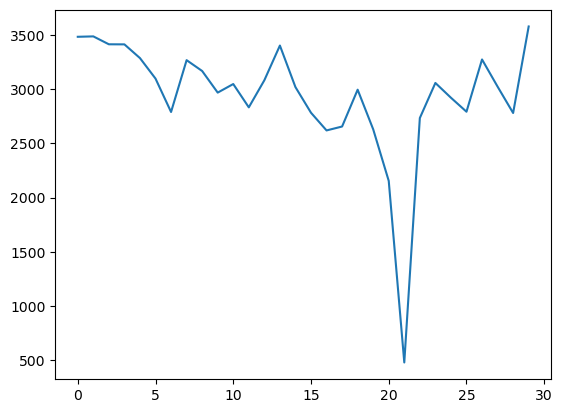

In [8]:
plt.plot(total_rewards)
plt.show()

In [ ]:
plt.plot(critic_loss)
plt.show()

In [2]:
Nd = 2
n_step = 3000

sp = vdp.randomPrimalStates(1)
sd = vdp.randomDebrisStates(Nd)
op, od = vdp.getObss(sp, sd)
td_sim = dict(zip(buffer_keys, [[] for _ in buffer_keys]))
for step in range(n_step):        
    actions, _ = LD.act(op, od)
    (next_sp, next_sd), rewards, dones, (next_op, next_od) = vdp.propagate(sp, sd, actions)
    data = (op, od, actions, rewards, next_op, next_od, dones)
    data = [d.detach().cpu() for d in data]
    [td_sim[buffer_keys[i]].extend(data[i]) for i in range(len(data))]
    sp, sd, op, od = next_sp, next_sd, next_op, next_od

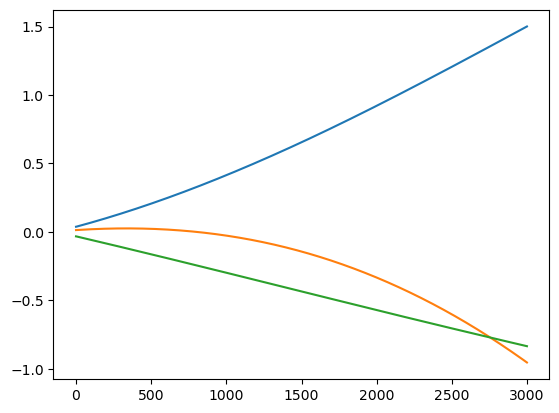

In [3]:
plt.plot(torch.stack(td_sim["primal_obss"])[:,:3].numpy())
plt.show()

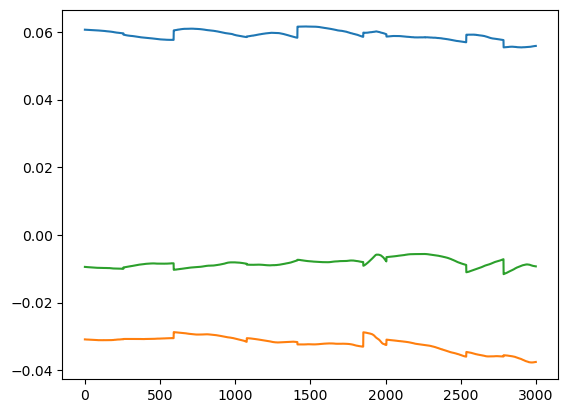

In [4]:
plt.plot(torch.stack(td_sim["actions"])[:,:3].numpy())
plt.show()

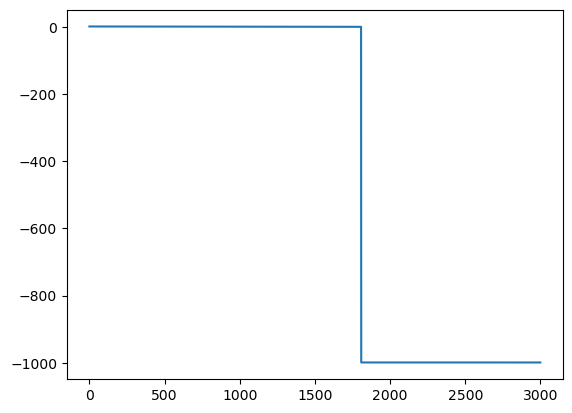

In [5]:
plt.plot(torch.stack(td_sim["rewards"]).numpy())
plt.show()